In [22]:
#Libraries we are using (might add more later)
import torch #Pytorch
import matplotlib as plt #Matplotlib
import seaborn as sns #Seaborn
import numpy as np
import pandas as pd
import math as math
import os
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split # Splits data into training/testing sets
from sklearn.preprocessing import StandardScaler #scales data for better preformance

# Electric Power Consumption 
The data set for this project can be found [here](https://www.kaggle.com/datasets/fedesoriano/electric-power-consumption).

In [23]:
df = pd.read_csv('powerconsumption.csv')
print(f'Features: {df.columns} \nShape: {df.shape}')

Features: Index(['Datetime', 'Temperature', 'Humidity', 'WindSpeed',
       'GeneralDiffuseFlows', 'DiffuseFlows', 'PowerConsumption_Zone1',
       'PowerConsumption_Zone2', 'PowerConsumption_Zone3'],
      dtype='object') 
Shape: (52416, 9)


#### Input / Output

<p>Inputs: Date + time, Temperature, Humidity, Windspeed </p>
Outputs = Power consumption in certain zones (lets start with zone 1)

In [24]:
display(df)

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964
...,...,...,...,...,...,...,...,...,...
52411,12/30/2017 23:10,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212
52412,12/30/2017 23:20,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152
52413,12/30/2017 23:30,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259
52414,12/30/2017 23:40,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504


In [25]:
df[['Date', 'Time']] = df['Datetime'].str.split(" ", expand=True)
df = df.drop('Datetime',axis=1)

In [26]:
display(df)

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,Date,Time
0,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,1/1/2017,0:00
1,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,1/1/2017,0:10
2,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,1/1/2017,0:20
3,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,1/1/2017,0:30
4,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,1/1/2017,0:40
...,...,...,...,...,...,...,...,...,...,...
52411,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212,12/30/2017,23:10
52412,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152,12/30/2017,23:20
52413,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259,12/30/2017,23:30
52414,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504,12/30/2017,23:40


In [27]:
col = df.pop('Date')
df.insert(0,'Date',col)
col = df.pop('Time')
df.insert(1,'Time',col)

In [28]:
display(df)

,Date,Time,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,1/1/2017,0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017,0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017,0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017,0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017,0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964
...,...,...,...,...,...,...,...,...,...,...
52411,12/30/2017,23:10,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212
52412,12/30/2017,23:20,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152
52413,12/30/2017,23:30,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259
52414,12/30/2017,23:40,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504


In [29]:
df.isna().sum() #No na values :)

Date                      0
Time                      0
Temperature               0
Humidity                  0
WindSpeed                 0
GeneralDiffuseFlows       0
DiffuseFlows              0
PowerConsumption_Zone1    0
PowerConsumption_Zone2    0
PowerConsumption_Zone3    0
dtype: int64

In [30]:
print(df['PowerConsumption_Zone1'].min())
print(df['PowerConsumption_Zone1'].max())

13895.6962
52204.39512


#### Simple Neural Network

For a simple neural network, we will be looking at Zone 1, and estimating the power consumption while theyre rounded \
USE THE DATAFRAME: **dfs**

In [31]:
dfs = df.copy()

dfs = dfs.drop(['PowerConsumption_Zone2','PowerConsumption_Zone3'],axis=1)
dfs[['Month','Day','Year']] = df['Date'].str.split("/",expand=True)
dfs[['Month', 'Day', 'Year']] = dfs[['Month', 'Day', 'Year']].astype(int)
dfs = dfs.drop(['Date'],axis=1)
display(dfs)

,Time,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,Month,Day,Year
0,0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,1,1,2017
1,0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,1,1,2017
2,0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,1,1,2017
3,0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,1,1,2017
4,0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,1,1,2017
...,...,...,...,...,...,...,...,...,...,...
52411,23:10,7.010,72.4,0.080,0.040,0.096,31160.45627,12,30,2017
52412,23:20,6.947,72.6,0.082,0.051,0.093,30430.41825,12,30,2017
52413,23:30,6.900,72.8,0.086,0.084,0.074,29590.87452,12,30,2017
52414,23:40,6.758,73.0,0.080,0.066,0.089,28958.17490,12,30,2017


Time Ranges:\
1: 6 AM - 12 PM : DAY \
2: 12 PM - 6 PM: AFTERNOON \
3: 6 PM - 9 PM: Evening \
4: 9 PM - 12 AM: Night \
5: 12 AM - 6 AM: Late Night


In [32]:
def cat(hour):
    if 6<= hour < 12:
        return 1
    if 12 <= hour < 18:
        return 2
    if 18 <= hour < 21:
        return 3
    if 21 <= hour < 24:
        return 4
    if 0<= hour <6:
        return 5

In [33]:
dfs['Time'] = pd.to_datetime(dfs['Time'], format='%H:%M')
dfs['Time'] = dfs['Time'].dt.round('h').dt.hour
dfs.drop('Year',axis=1)


,Time,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,Month,Day
0,0,6.559,73.8,0.083,0.051,0.119,34055.69620,1,1
1,0,6.414,74.5,0.083,0.070,0.085,29814.68354,1,1
2,0,6.313,74.5,0.080,0.062,0.100,29128.10127,1,1
3,0,6.121,75.0,0.083,0.091,0.096,28228.86076,1,1
4,1,5.921,75.7,0.081,0.048,0.085,27335.69620,1,1
...,...,...,...,...,...,...,...,...,...
52411,23,7.010,72.4,0.080,0.040,0.096,31160.45627,12,30
52412,23,6.947,72.6,0.082,0.051,0.093,30430.41825,12,30
52413,0,6.900,72.8,0.086,0.084,0.074,29590.87452,12,30
52414,0,6.758,73.0,0.080,0.066,0.089,28958.17490,12,30


In [34]:
col = dfs.pop('Day')
dfs.insert(0,'Day',col)
col = dfs.pop('Month')
dfs.insert(0,'Month',col)

In [35]:
# dfs['Temperature']=dfs['Temperature'].round(0)
# dfs['Humidity']=dfs['Humidity'].round(0)
# dfs['WindSpeed']=dfs['WindSpeed'].round(0)

print(f'Unique Values of Time after mapping: {dfs['Time'].nunique()}')
print(f'Unique Values of Temperature after rounding: {dfs['Temperature'].nunique()}')
print(f'Unique values of Humidity after rounding: {dfs['Humidity'].nunique()}')
print(f'Unique values of Windspeed after rounding: {dfs['WindSpeed'].round(1).nunique()}')
print(f'Unique values of PowerConsumption after rounding: {dfs['PowerConsumption_Zone1'].round(2).nunique()}')

dfs['PowerConsumption_Zone1'] = (df['PowerConsumption_Zone1']/100000).round(4) * 100000
dfs['PowerConsumption_Zone1']=dfs['PowerConsumption_Zone1'].div(10)

Unique Values of Time after mapping: 24
Unique Values of Temperature after rounding: 3437
Unique values of Humidity after rounding: 4443
Unique values of Windspeed after rounding: 56
Unique values of PowerConsumption after rounding: 27669


In [36]:
display(dfs)

,Month,Day,Time,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,Year
0,1,1,0,6.559,73.8,0.083,0.051,0.119,3406.0,2017
1,1,1,0,6.414,74.5,0.083,0.070,0.085,2981.0,2017
2,1,1,0,6.313,74.5,0.080,0.062,0.100,2913.0,2017
3,1,1,0,6.121,75.0,0.083,0.091,0.096,2823.0,2017
4,1,1,1,5.921,75.7,0.081,0.048,0.085,2734.0,2017
...,...,...,...,...,...,...,...,...,...,...
52411,12,30,23,7.010,72.4,0.080,0.040,0.096,3116.0,2017
52412,12,30,23,6.947,72.6,0.082,0.051,0.093,3043.0,2017
52413,12,30,0,6.900,72.8,0.086,0.084,0.074,2959.0,2017
52414,12,30,0,6.758,73.0,0.080,0.066,0.089,2896.0,2017


In [37]:
y = dfs['PowerConsumption_Zone1'].to_numpy()
y = y- y.min()
print(y.min())

X = dfs[['Month','Day','Time','Temperature','Humidity','WindSpeed']].to_numpy()
print(X[0].size)


outputSize = int(y.max())
print(type(outputSize))
print(dfs['PowerConsumption_Zone1'].nunique())
print(dfs['PowerConsumption_Zone1'].value_counts())
print(y.max())

0.0
6
<class 'int'>
3268
PowerConsumption_Zone1
3423.0    47
3469.0    46
3246.0    44
3514.0    44
2292.0    42
          ..
1752.0     1
1738.0     1
4858.0     1
5055.0     1
5069.0     1
Name: count, Length: 3268, dtype: int64
3830.0


In [38]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()

      
        self.fc1 = nn.Linear(X[0].size,300)
        self.fc2 = nn.Linear(300,outputSize+200)
        
    
    def forward(self,x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
        




In [39]:
model = NeuralNetwork()
print(model)
y = dfs['PowerConsumption_Zone1'].to_numpy()
display(dfs)
y = y - y.min()
outputSize = int(y.max())
print(y.max())
print(y.min())

NeuralNetwork(
  (relu): ReLU()
  (fc1): Linear(in_features=6, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=4030, bias=True)
)


,Month,Day,Time,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,Year
0,1,1,0,6.559,73.8,0.083,0.051,0.119,3406.0,2017
1,1,1,0,6.414,74.5,0.083,0.070,0.085,2981.0,2017
2,1,1,0,6.313,74.5,0.080,0.062,0.100,2913.0,2017
3,1,1,0,6.121,75.0,0.083,0.091,0.096,2823.0,2017
4,1,1,1,5.921,75.7,0.081,0.048,0.085,2734.0,2017
...,...,...,...,...,...,...,...,...,...,...
52411,12,30,23,7.010,72.4,0.080,0.040,0.096,3116.0,2017
52412,12,30,23,6.947,72.6,0.082,0.051,0.093,3043.0,2017
52413,12,30,0,6.900,72.8,0.086,0.084,0.074,2959.0,2017
52414,12,30,0,6.758,73.0,0.080,0.066,0.089,2896.0,2017


3830.0
0.0


In [40]:
#The criterion is the loss function,
lossF = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.01)

In [41]:
#normalize the features using Standard scalar
scalar = StandardScaler()


X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)


#pytorch tensors


X_train_tensor = torch.tensor(X_train,dtype=torch.float32)
X_test_tensor = torch.tensor(X_test,dtype=torch.float32)

y_train_tensor = torch.tensor(y_train,dtype=torch.long)
y_test_tensor = torch.tensor(y_test,dtype=torch.long)


print(X_train_tensor)


tensor([[ 1.3093, -1.2169, -1.0747, -0.6343,  1.1775, -0.8049],
        [-0.4362, -0.9888,  0.2272,  1.0134, -1.6129, -0.8011],
        [-0.7272,  0.6082, -1.3640, -0.5225,  1.4220, -0.8049],
        ...,
        [ 1.0184,  0.8363,  1.5290,  0.2395,  0.6820,  1.2560],
        [ 1.0184,  1.6348,  0.2272,  0.4046,  0.4053,  1.2577],
        [-1.5999,  0.3801,  1.6737, -1.4151, -0.8651, -0.7968]])


In [42]:
# This code is no longer needed since the model was trained and is saved in model.pth
'''
num_epocs = 50
for epoch in range(num_epocs):
    outputs = model(X_train_tensor)
    loss = lossF(outputs,y_train_tensor)

    optimizer.zero_grad()
    loss.backward() 
    optimizer.step()

    if (epoch+1)%5 == 0:
        print(f'Epoch [{epoch+1}/{num_epocs}, Loss {loss.item(): .4f}]') 

'''

"\nnum_epocs = 50\nfor epoch in range(num_epocs):\n    outputs = model(X_train_tensor)\n    loss = lossF(outputs,y_train_tensor)\n\n    optimizer.zero_grad()\n    loss.backward() \n    optimizer.step()\n\n    if (epoch+1)%5 == 0:\n        print(f'Epoch [{epoch+1}/{num_epocs}, Loss {loss.item(): .4f}]') \n\n"

In [43]:
#torch.save(model,"model.pth")
model = torch.load("model.pth")
torch.save(model,"model2.pth")
model.eval()

C:\Users\zainm\AppData\Local\Temp\ipykernel_76720\1118483977.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("model.pth")


NeuralNetwork(
  (relu): ReLU()
  (fc1): Linear(in_features=6, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=3830, bias=True)
)

Accuracy on test data: 37.21%


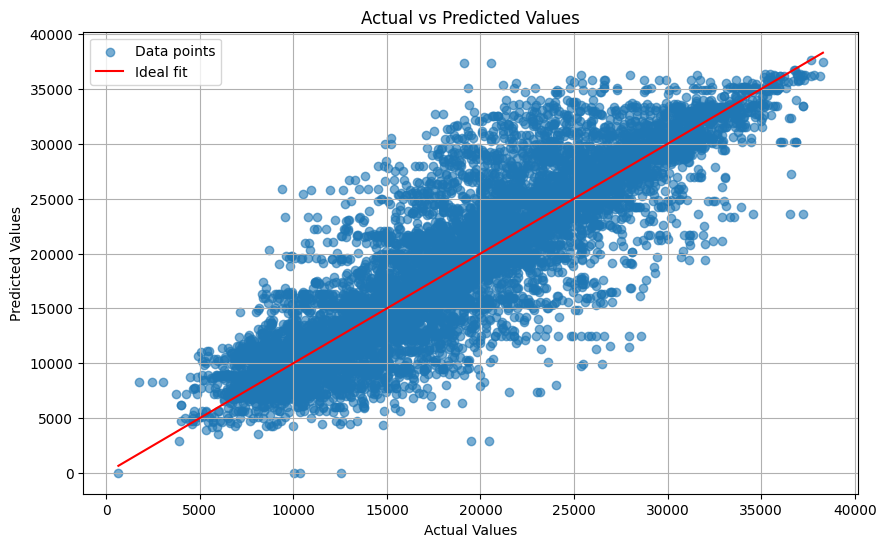

In [52]:
import matplotlib.pyplot as plt
with torch.no_grad():  # Disable grad tracking
    outputs = model(X_test_tensor)  # Get model predictions for test data
    _, predicted = torch.max(outputs, 1)  # Get the class with the highest score

    # Calculate accuracy
    correct = (abs(predicted - y_test_tensor) < 100).sum().item()  # Count correct predictions
    accuracy = correct / y_test_tensor.size(0)  # Accuracy = correct / total
    print(f'Accuracy on test data: {accuracy * 100:.2f}%')

    # Prepare data for visualization
    predicted_values = (predicted.numpy() + y.min()) * 10
    actual_values = (y_test_tensor.numpy() + y.min()) * 10

    # Create a Pandas DataFrame
    data = pd.DataFrame({
        'Actual': actual_values,
        'Predicted': predicted_values
    })

    # Plot the actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(data['Actual'], data['Predicted'], alpha=0.6, label='Data points')
    plt.plot([data['Actual'].min(), data['Actual'].max()],
             [data['Actual'].min(), data['Actual'].max()], color='red', label='Ideal fit')

    plt.title('Actual vs Predicted Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()

So our data when given a margin of error of about predicts the correct output energy with a margin of error of about 3000 watts with a 72.25% accuracy 

Step 1: Feature Engineering

We can incorporate lag features so how much power was used in the prior days

In [45]:
display(dfs)

,Month,Day,Time,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,Year
0,1,1,0,6.559,73.8,0.083,0.051,0.119,3406.0,2017
1,1,1,0,6.414,74.5,0.083,0.070,0.085,2981.0,2017
2,1,1,0,6.313,74.5,0.080,0.062,0.100,2913.0,2017
3,1,1,0,6.121,75.0,0.083,0.091,0.096,2823.0,2017
4,1,1,1,5.921,75.7,0.081,0.048,0.085,2734.0,2017
...,...,...,...,...,...,...,...,...,...,...
52411,12,30,23,7.010,72.4,0.080,0.040,0.096,3116.0,2017
52412,12,30,23,6.947,72.6,0.082,0.051,0.093,3043.0,2017
52413,12,30,0,6.900,72.8,0.086,0.084,0.074,2959.0,2017
52414,12,30,0,6.758,73.0,0.080,0.066,0.089,2896.0,2017


In [53]:
#Unfortunately, this will cause us to lose 7 rows of data but that isnt that bad. (Due to nan values)

dfs['Lag1'] = dfs['PowerConsumption_Zone1'].shift(1) #Lag 1 day behind
dfs['Lag2'] = dfs['PowerConsumption_Zone1'].shift(3) #Lag 3 days behind
dfs['Lag3'] = dfs['PowerConsumption_Zone1'].shift(7) #Lag approx 1 week behind
dfs['Rolling Mean 7'] = dfs['PowerConsumption_Zone1'].rolling(window=7).mean()
dfs = dfs[7:]
display(dfs)

,Month,Day,Time,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,Year,Lag1,Lag2,Lag3,Rolling Mean 7,month_sin,month_cos,day_sin,day_cos,time_sin,time_cos
14,1,1,2,4.975,78.9,0.083,0.055,0.152,2209.0,2017,2233.0,2354.0,2545.0,2341.714286,5.000000e-01,0.866025,2.079117e-01,0.978148,0.500000,0.866025
15,1,1,2,4.897,79.1,0.083,0.070,0.096,2190.0,2017,2209.0,2300.0,2478.0,2300.571429,5.000000e-01,0.866025,2.079117e-01,0.978148,0.500000,0.866025
16,1,1,3,5.020,79.7,0.081,0.051,0.134,2169.0,2017,2190.0,2233.0,2428.0,2263.571429,5.000000e-01,0.866025,2.079117e-01,0.978148,0.707107,0.707107
17,1,1,3,5.407,78.5,0.082,0.062,0.163,2148.0,2017,2169.0,2209.0,2390.0,2229.000000,5.000000e-01,0.866025,2.079117e-01,0.978148,0.707107,0.707107
18,1,1,3,5.169,77.9,0.083,0.066,0.108,2111.0,2017,2148.0,2190.0,2354.0,2194.285714,5.000000e-01,0.866025,2.079117e-01,0.978148,0.707107,0.707107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52411,12,30,23,7.010,72.4,0.080,0.040,0.096,3116.0,2017,3216.0,3339.0,3492.0,3319.571429,-2.449294e-16,1.000000,-2.449294e-16,1.000000,-0.258819,0.965926
52412,12,30,23,6.947,72.6,0.082,0.051,0.093,3043.0,2017,3116.0,3282.0,3474.0,3258.000000,-2.449294e-16,1.000000,-2.449294e-16,1.000000,-0.258819,0.965926
52413,12,30,0,6.900,72.8,0.086,0.084,0.074,2959.0,2017,3043.0,3216.0,3432.0,3190.428571,-2.449294e-16,1.000000,-2.449294e-16,1.000000,0.000000,1.000000
52414,12,30,0,6.758,73.0,0.080,0.066,0.089,2896.0,2017,2959.0,3116.0,3378.0,3121.571429,-2.449294e-16,1.000000,-2.449294e-16,1.000000,0.000000,1.000000


In [47]:
#TRIG FEATURES


In [48]:
from sklearn.preprocessing import FunctionTransformer

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x/period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x/period * 2 * np.pi))

In [49]:
dfs['month_sin'] = sin_transformer(12).fit_transform(dfs[['Month']])['Month']
dfs['month_cos'] = cos_transformer(12).fit_transform(dfs[['Month']])['Month']

dfs['day_sin'] = sin_transformer(30).fit_transform(dfs[['Day']])['Day']
dfs['day_cos'] = cos_transformer(30).fit_transform(dfs[['Day']])['Day']

dfs['time_sin'] = sin_transformer(24).fit_transform(dfs[['Time']])['Time']
dfs['time_cos'] = cos_transformer(24).fit_transform(dfs[['Time']])['Time']
#a

In [50]:
display(dfs)

,Month,Day,Time,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,Year,Lag1,Lag2,Lag3,Rolling Mean 7,month_sin,month_cos,day_sin,day_cos,time_sin,time_cos
7,1,1,1,5.496,78.2,0.085,0.055,0.093,2545.0,2017,2600.0,2734.0,3406.0,2751.142857,5.000000e-01,0.866025,2.079117e-01,0.978148,0.258819,0.965926
8,1,1,1,5.678,78.1,0.081,0.066,0.141,2478.0,2017,2545.0,2662.0,2981.0,2679.285714,5.000000e-01,0.866025,2.079117e-01,0.978148,0.258819,0.965926
9,1,1,2,5.491,77.3,0.082,0.062,0.111,2428.0,2017,2478.0,2600.0,2913.0,2610.000000,5.000000e-01,0.866025,2.079117e-01,0.978148,0.500000,0.866025
10,1,1,2,5.516,77.5,0.081,0.051,0.108,2390.0,2017,2428.0,2545.0,2823.0,2548.142857,5.000000e-01,0.866025,2.079117e-01,0.978148,0.500000,0.866025
11,1,1,2,5.471,76.7,0.083,0.059,0.126,2354.0,2017,2390.0,2478.0,2734.0,2493.857143,5.000000e-01,0.866025,2.079117e-01,0.978148,0.500000,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52411,12,30,23,7.010,72.4,0.080,0.040,0.096,3116.0,2017,3216.0,3339.0,3492.0,3319.571429,-2.449294e-16,1.000000,-2.449294e-16,1.000000,-0.258819,0.965926
52412,12,30,23,6.947,72.6,0.082,0.051,0.093,3043.0,2017,3116.0,3282.0,3474.0,3258.000000,-2.449294e-16,1.000000,-2.449294e-16,1.000000,-0.258819,0.965926
52413,12,30,0,6.900,72.8,0.086,0.084,0.074,2959.0,2017,3043.0,3216.0,3432.0,3190.428571,-2.449294e-16,1.000000,-2.449294e-16,1.000000,0.000000,1.000000
52414,12,30,0,6.758,73.0,0.080,0.066,0.089,2896.0,2017,2959.0,3116.0,3378.0,3121.571429,-2.449294e-16,1.000000,-2.449294e-16,1.000000,0.000000,1.000000
